In [3]:
# Standard imports
from pathlib import Path
import pandas as pd
import numpy as np

# Import our refactored modules
from athletes_brain.fig1 import (
    Fig1Config,
    AthletesBrainDataLoader,
    GroupComparison,
    BrainPlotter,
    generate_figure1,
)

# Import specific functions for focused analysis
from athletes_brain.fig1.main import analyze_specific_comparison, get_most_significant_regions

2025-09-08 10:21:36.114 | INFO     | athletes_brain.config:<module>:11 - PROJ_ROOT path is: /home/galkepler/Projects/athletes_brain


In [4]:
# Initialize configuration
config = Fig1Config()

config.METRICS = ["gm_vol", "adc"]
# Set up matplotlib configuration for consistent plots
config.setup_matplotlib_config()

# Display configuration
print(f"Atlas: {config.ATLAS}")
print(f"Metrics: {config.METRICS}")
print(
    f"Group labels: {config.CLIMBER_GROUP_LABEL}, {config.BJJ_GROUP_LABEL}, {config.CONTROL_GROUP_LABEL}"
)
print(f"P-value threshold: {config.P_THRESHOLD}")
print(f"Visualization range: [{config.VMIN}, {config.VMAX}]")

Atlas: schaefer2018tian2020_400_7
Metrics: ['gm_vol', 'adc']
Group labels: Climbing, Bjj, Control
P-value threshold: 0.05
Visualization range: [-5, 5]


In [5]:
FORCE = False
# Generate complete Figure 1
output_dir = Path("/media/storage/phd") / "athletes_brain" / "figures" / "learners"
# generate_figure1(output_dir=output_dir, config=config)

In [6]:
# Initialize data loader
data_loader = AthletesBrainDataLoader(config)

# Load all data
metric_data, parcels, nifti_path, nifti_matlab_path = data_loader.load_all_data()

print(f"Loaded {len(metric_data)} metrics")
print(f"Loaded {len(parcels)} brain parcels")
print(f"Metrics: {list(metric_data.keys())}")

metric_data = {key: val.drop(val[(~val["cs_valid"]) & ~val["learner"]].index) for key, val in metric_data.items()}

# Display sample data (demographics)
d = metric_data["gm_vol"].drop_duplicates(subset=["subject_code"], keep="first")
print(f"Total N participants: {d.shape[0]}")
athletes = d[d["target"]]
climbers = athletes[athletes["group"] == config.CLIMBER_GROUP_LABEL]
bjjers = athletes[athletes["group"] == config.BJJ_GROUP_LABEL]

learners = d[d["learner"]]
climbers_learners = learners[learners["group"] == config.CLIMBER_GROUP_LABEL]
bjjers_learners = learners[learners["group"] == config.BJJ_GROUP_LABEL]

print(f"Total N athletes: {athletes.shape[0]}")
print(f"Total N climbers: {climbers.shape[0]}")
print(f"Total N BJJ practitioners: {bjjers.shape[0]}")
print(f"Total N learners: {learners.shape[0]}")
print(f"Total N climbers (learners): {climbers_learners.shape[0]}")
print(f"Total N BJJ practitioners (learners): {bjjers_learners.shape[0]}")

2025-09-08 10:21:39.396 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:48 - Loading metric data...
2025-09-08 10:21:39.397 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading gm_vol data


/home/galkepler/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (1,6,7,8,9,10,11,12,68,74,78,79,80,81,82,84,85,86,87,92,93,94,95,96,97,99,113,115,116,121,122,123,124,125,132,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-09-08 10:22:03.160 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:82 - Loaded 1595356 records for gm_vol
2025-09-08 10:22:03.161 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading adc data


/home/galkepler/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (16,23,24,25,26,27,33,39,43,44,45,46,47,49,50,51,52,57,58,59,60,61,62,64,78,80,81,86,87,88,89,96,97,98,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-09-08 10:22:17.124 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:82 - Loaded 1600350 records for adc
2025-09-08 10:22:17.124 | SUCCESS  | athletes_brain.fig1.data_loader:load_metric_data:84 - Successfully loaded 2 metrics
2025-09-08 10:22:17.124 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:32 - Loading atlas data for schaefer2018tian2020_400_7
2025-09-08 10:22:17.163 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:39 - Loaded 454 parcels from atlas
Loaded 2 metrics
Loaded 454 brain parcels
Metrics: ['gm_vol', 'adc']
Total N participants: 1682
Total N athletes: 139
Total N climbers: 80
Total N BJJ practitioners: 51
Total N learners: 239
Total N climbers (learners): 116
Total N BJJ practitioners (learners): 99


In [7]:
for _, df in metric_data.items():
    df["timestamp"] = pd.to_datetime(df["session_id"], format="%Y%m%d%H%M")


In [8]:
import math
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from numpy.linalg import LinAlgError
from tqdm import tqdm

def _get_beta_and_vcov(res):
    """
    Return (beta_vec, vcov_mat, names_list) for fixed effects only,
    across MixedLM and OLS (incl. cluster-robust wrappers).
    """
    # Preferred path for MixedLM: use fixed effects only
    fe = getattr(res, "fe_params", None)
    if isinstance(fe, pd.Series):
        P = fe.values.astype(float)
        Vfull = res.cov_params()
        if isinstance(Vfull, pd.DataFrame):
            V = Vfull.loc[fe.index, fe.index].values
        else:
            V = np.asarray(Vfull)[:len(P), :len(P)]
        names = list(fe.index)
        return P, V, names

    # Generic path (OLS etc.)
    P = getattr(res, "params", None)
    V = res.cov_params()
    # names
    try:
        names = list(res.model.exog_names)
    except Exception:
        names = None

    if isinstance(P, pd.Series):
        names = list(P.index) if names is None else names
        P = P.values.astype(float)
    else:
        P = np.asarray(P, dtype=float).ravel()
        if names is None:
            names = [f"x{i}" for i in range(len(P))]

    V = V.values if isinstance(V, pd.DataFrame) else np.asarray(V, dtype=float)
    return P, V, names


def lincom(res, coefs, *, warn_missing=False):
    """
    Linear combo on a statsmodels result.
    coefs: dict {param_name: weight}
    Returns: (est, se, z, p, lo, hi)
    """
    P, V, names = _get_beta_and_vcov(res)
    name_to_idx = {n: i for i, n in enumerate(names)}
    L = np.zeros_like(P, dtype=float)

    missing = []
    for name, w in coefs.items():
        if name in name_to_idx:
            L[name_to_idx[name]] = w
        else:
            missing.append(name)

    if warn_missing and missing:
        print(f"[lincom] Missing params (treated as 0): {missing}\nAvailable: {names}")

    est = float(L @ P)
    var = float(L @ V @ L)
    se  = np.sqrt(max(var, 0.0))
    z   = est / se if se > 0 else np.nan
    # two-sided normal p:
    p   = 2 * 0.5 * math.erfc(abs(z) / np.sqrt(2)) if se > 0 else np.nan
    lo, hi = est - 1.96 * se, est + 1.96 * se
    return est, se, z, p, lo, hi


def _sex_term(d):
    return " + C(sex)" if ("sex" in d.columns and d["sex"].nunique() > 1) else ""

def _tiv_term(metric: str):
    return " + tiv" if "vol" in str(metric).lower() else ""

def add_scaled_covariates(d: pd.DataFrame, metric: str) -> pd.DataFrame:
    d = d.copy()
    # Age: center, then square the centered term
    if "age_at_scan" in d.columns:
        d["age_c"]  = d["age_at_scan"] - d["age_at_scan"].mean()
        d["age_c2"] = d["age_c"] ** 2
    else:
        d["age_c"] = d["age_c2"] = 0.0

    # TIV: z-score if present and used for 'vol' metrics
    if "tiv" in d.columns and "vol" in str(metric).lower():
        sd = d["tiv"].std(ddof=0)
        d["tiv_z"] = (d["tiv"] - d["tiv"].mean()) / (sd if sd and sd > 0 else 1.0)
    # else:
    #     d["tiv_z"] = 0.0

    return d


# ---------- primary Athlete vs Learner model ----------
def fit_roi_model(d, metric:str, time_variable:str="time_months"):
    d = add_scaled_covariates(d, metric)
    d["tp_label"]  = pd.Categorical(d["tp_label"], categories=["pre","post"])
    d["condition"] = pd.Categorical(d["condition"], categories=["Athlete","Learner"])
    if "sex" in d:
        d["sex"] = d["sex"].astype("category")

    if d["condition"].nunique() < 2:
        return None, "one_group_only"
    if d["subject_code"].nunique() < 3:
        return None, "too_few_subjects"

    sex_term = " + C(sex)" if ("sex" in d and d["sex"].nunique() > 1) else ""
    tiv_term = " + tiv_z"  if ("vol" in str(metric).lower()) else ""

    formula = (
        f"y ~ {time_variable} * C(condition, levels=['Athlete','Learner'])"
        " + age_c + age_c2" + sex_term + tiv_term
    )
    try:
        m = smf.mixedlm(formula, data=d, groups=d["subject_code"]).fit(reml=True, maxiter=400)
        return m, "mixed"
    except (LinAlgError, ValueError):
        return None, "mixed_fail"
    # except (LinAlgError, ValueError):
    #     ols = smf.ols(formula, data=d).fit()
    #     return ols.get_robustcov_results(cov_type="cluster", groups=d["subject_code"]), "ols_cluster"


def extract_effects(res, time_variable:str = "time_months"):
    """Key effects with Athlete baseline."""
    is_mixed = hasattr(res, "random_effects") or hasattr(res, "cov_re")
    # p_post   = "C(tp_label, levels=['pre', 'post'])[T.post]"
    p_post = time_variable
    p_L      = "C(condition, levels=['Athlete', 'Learner'])[T.Learner]"
    p_postxL = p_post + ":" + p_L

    out = {}
    est, se, z, p, lo, hi = lincom(res, {p_post: 1.0})
    out.update(dict(beta_post=est, se_post=se, z_post=z, p_post=p, lo_post=lo, hi_post=hi))

    est, se, z, p, lo, hi = lincom(res, {p_L: 1.0})
    out.update(dict(beta_learner_pre=est, se_learner_pre=se, z_learner_pre=z, p_learner_pre=p,
                    lo_learner_pre=lo, hi_learner_pre=hi))

    est, se, z, p, lo, hi = lincom(res, {p_postxL: 1.0})
    out.update(dict(beta_postx_learner=est, se_postx_learner=se, z_postx_learner=z,
                    p_postx_learner=p, lo_postx_learner=lo, hi_postx_learner=hi))

    est, se, z, p, lo, hi = lincom(res, {p_post: 1.0, p_postxL: 1.0})
    out.update(dict(beta_learner_post_change=est, se_learner_post_change=se,
                    p_learner_post_change=p, lo_learner_post_change=lo, hi_learner_post_change=hi))

    out["model"] = "mixed" if is_mixed else "ols_cluster"
    out["converged"] = getattr(res, "converged", np.nan)
    return out

# ---------- learners-only: pre/post model ----------
def fit_learners_prepost(d, metric:str):
    dl = d.query("condition == 'Learner' and tp_label in ['pre', 'post']").copy()
    has_both = dl.groupby("subject_code")["tp_label"].transform(lambda s: {"pre","post"}.issubset(set(s)))
    dl = dl[has_both]
    if dl["subject_code"].nunique() < 2:
        return None, "L_too_few_subjects"

    dl = add_scaled_covariates(dl, metric)
    if "sex" in dl: dl["sex"] = dl["sex"].astype("category")
    formula = "y ~ C(tp_label, levels=['pre', 'post']) + age_c + age_c2" \
              + (" + C(sex)" if ("sex" in dl and dl["sex"].nunique()>1) else "") \
              + (" + tiv_z" if ("vol" in str(metric).lower()) else "")
    try:
        m = smf.mixedlm(formula, data=dl, groups=dl["subject_code"]).fit(reml=True, maxiter=400)
        status = "L_mixed"
    except (LinAlgError, ValueError):
        m = smf.ols(formula, data=dl).fit().get_robustcov_results(cov_type="cluster", groups=dl["subject_code"])
        status = "L_ols_cluster"
    
    # extract the pre→post effect within learners
    term = "C(tp_label, levels=['pre', 'post'])[T.post]"
    est, se, z, p, lo, hi = lincom(m, {term: 1.0})
    out = {
        "L_post_beta": est, "L_post_se": se, "L_post_z": z, "L_post_p": p,
        "L_post_lo": lo, "L_post_hi": hi,
        "L_model": "mixed" if status == "L_mixed" else "ols_cluster",
        "L_status": status
    }
    return out, status

# ---------- learners-only: monthly slope model ----------
def fit_learners_slope(d, metric:str, time_variable:str="time_months"):
    dl = d.query("condition == 'Learner' and tp_label in ['pre', 'post']").copy()
    has_both = dl.groupby("subject_code")["tp_label"].transform(lambda s: {"pre","post"}.issubset(set(s)))
    dl = dl[has_both]
    if dl["subject_code"].nunique() < 2: return None, "Lsl_too_few_subjects"

    dl = add_scaled_covariates(dl, metric)
    if "sex" in dl: dl["sex"] = dl["sex"].astype("category")
    formula = f"y ~ {time_variable} + age_c + age_c2" \
              + (" + C(sex)" if ("sex" in dl and dl["sex"].nunique()>1) else "") \
              + (" + tiv_z" if ("vol" in str(metric).lower()) else "")
    try:
        m = smf.mixedlm(formula, data=dl, groups=dl["subject_code"]).fit(reml=True, maxiter=400)
        status = "Lsl_mixed"
    except (LinAlgError, ValueError):
        m = smf.ols(formula, data=dl).fit().get_robustcov_results(cov_type="cluster", groups=dl["subject_code"])
        status = "Lsl_ols_cluster"
    # extract time_months effect as before...


    term = time_variable
    est, se, z, p, lo, hi = lincom(m, {term: 1.0})
    out = {
        "L_slope_month_beta": est, "L_slope_month_se": se, "L_slope_month_z": z,
        "L_slope_month_p": p, "L_slope_month_lo": lo, "L_slope_month_hi": hi,
        "L_slope_model": "mixed" if status == "Lsl_mixed" else "ols_cluster",
        "L_slope_status": status
    }
    return out, status

In [9]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.formula.api as smf

def _fit_mixed_or_ols(formula: str, d: pd.DataFrame):
    """Try MixedLM; on failure, fall back to OLS with subject-clustered SEs."""
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            m = smf.mixedlm(formula, data=d, groups=d["subject_code"]).fit(
                reml=True, maxiter=500
            )
        return m, "mixed"
    except Exception:
        ols = smf.ols(formula, data=d).fit()
        return ols.get_robustcov_results(cov_type="cluster", groups=d["subject_code"]), "ols_cluster"


def fit_roi_model_both(d: pd.DataFrame, metric: str, include_sport: bool = (True)):
    """
    3-level condition: Other (baseline) / Athlete / MotorLearner
    Fits:
      (1) Slope:  y ~ time_months * condition + covars
      (2) Factor: y ~ post(pre/post) * condition + covars
    Returns dict with fitted models + status.
    """
    out = {}

    # scale covariates
    d = add_scaled_covariates(d, metric).copy()

    # ensure categories
    d["tp_label"]  = pd.Categorical(d["tp_label"],  categories=["pre", "post"])
    # IMPORTANT: baseline = "Other"
    d["condition"] = pd.Categorical(d["condition"], categories=["Other", "Athlete", "MotorLearner"])
    if "sex" in d:   d["sex"]   = d["sex"].astype("category")
    if "sport" in d: d["sport"] = d["sport"].astype("category")

    # keep only subjects with both pre & post
    d = d[d["tp_label"].isin(["pre","post"])].copy()
    has_both = d.groupby("subject_code")["tp_label"].transform(lambda s: {"pre","post"}.issubset(set(s)))
    d = d[has_both].copy()

    # minimal sample checks for primary contrast (Motor vs Other)
    need = d["condition"].isin(["Other","MotorLearner"]).groupby(d["subject_code"]).transform("any")
    if d["subject_code"].nunique() < 3 or d.loc[need, "condition"].nunique() < 2:
        return {"status_slope": "insufficient", "status_factor": "insufficient",
                "model_slope": None, "model_factor": None}

    sex_term   = " + C(sex)" if ("sex" in d and d["sex"].nunique() > 1) else ""
    tiv_term   = " + tiv_z"  if ("vol" in str(metric).lower()) else ""
    sport_term = " + C(sport)" if (include_sport and "sport" in d and d["sport"].nunique() > 1) else ""

    # slope model (time × condition; baseline Other)
    f_slope = (
        "y ~ time_months * C(condition, levels=['Other','Athlete','MotorLearner'])"
        " + age_c + age_c2" + sex_term + tiv_term + sport_term
    )
    m_slope, st_slope = _fit_mixed_or_ols(f_slope, d)
    out["model_slope"], out["status_slope"] = m_slope, st_slope

    # factor model (post × condition; baseline Other)
    f_factor = (
        "y ~ C(tp_label, levels=['pre','post']) * "
        "C(condition, levels=['Other','Athlete','MotorLearner'])"
        " + age_c + age_c2" + sex_term + tiv_term + sport_term
    )
    m_factor, st_factor = _fit_mixed_or_ols(f_factor, d)
    out["model_factor"], out["status_factor"] = m_factor, st_factor

    return out



def extract_effects_both(
    model_slope,
    model_factor,
    *,
    time_var: str = "time_months",
    lin=lincom,            # pass lincom_any here if you're using that helper
    warn_missing: bool = False
):
    """
    Extract primary (Motor vs Other) and secondary (Motor vs Athlete) contrasts,
    within-group changes/slopes, baseline PRE differences, and POST group diffs.

    Returns keys (if model present):
      # SLOPE (per month)
      slope_MvO_*, slope_MvA_*, slope_AvO_*,
      slope_motor_*, slope_athlete_*, slope_other_*,
      slope_MvO_pre_*, slope_AvO_pre_*
      # FACTOR (pre→post)
      factor_MvO_*, factor_MvA_*, factor_AvO_*,
      factor_motor_postchange_*, factor_athlete_postchange_*, factor_other_postchange_*,
      factor_MvO_pre_*, factor_AvO_pre_*,
      # POST group differences (helpful to report)
      factor_MvO_postdiff_*, factor_MvA_postdiff_*
    """
    out = {}

    # ---- SLOPE model (y ~ time_var * condition) ----
    if model_slope is not None:
        tm = time_var
        A  = "C(condition, levels=['Other', 'Athlete', 'MotorLearner'])[T.Athlete]"
        M  = "C(condition, levels=['Other', 'Athlete', 'MotorLearner'])[T.MotorLearner]"
        Ax = f"{tm}:{A}"
        Mx = f"{tm}:{M}"

        def put(prefix, coefs):
            est, se, z, p, lo, hi = lin(model_slope, coefs, warn_missing=warn_missing)
            out.update({f"{prefix}_est": est, f"{prefix}_se": se, f"{prefix}_z": z,
                        f"{prefix}_p": p, f"{prefix}_lo": lo, f"{prefix}_hi": hi})

        # Primary / secondary slope contrasts
        put("slope_MvO", {Mx: 1})                # Motor vs Other slope diff
        put("slope_MvA", {Mx: 1, Ax: -1})        # Motor vs Athlete slope diff
        put("slope_AvO", {Ax: 1})                # Athlete vs Other slope diff (context)

        # Within-group slopes (per month)
        put("slope_motor",   {tm: 1, Mx: 1})     # MotorLearner slope
        put("slope_athlete", {tm: 1, Ax: 1})     # Athlete slope
        put("slope_other",   {tm: 1})            # Other slope (baseline)

        # Baseline (t=0 / PRE) group differences vs Other
        put("slope_MvO_pre", {M: 1})
        put("slope_AvO_pre", {A: 1})

    # ---- FACTOR model (y ~ post * condition) ----
    if model_factor is not None:
        # IMPORTANT: match the exact term string your formula creates
        post = "C(tp_label, levels=['pre','post'])[T.post]"
        A  = "C(condition, levels=['Other', 'Athlete', 'MotorLearner'])[T.Athlete]"
        M  = "C(condition, levels=['Other', 'Athlete', 'MotorLearner'])[T.MotorLearner]"
        Ax = f"{post}:{A}"
        Mx = f"{post}:{M}"

        def putF(prefix, coefs):
            est, se, z, p, lo, hi = lin(model_factor, coefs, warn_missing=warn_missing)
            out.update({f"{prefix}_est": est, f"{prefix}_se": se, f"{prefix}_z": z,
                        f"{prefix}_p": p, f"{prefix}_lo": lo, f"{prefix}_hi": hi})

        # Primary / secondary Δ (pre→post) contrasts (Difference-in-Differences)
        putF("factor_MvO", {Mx: 1})                 # Motor vs Other Δ difference
        putF("factor_MvA", {Mx: 1, Ax: -1})         # Motor vs Athlete Δ difference
        putF("factor_AvO", {Ax: 1})                 # Athlete vs Other Δ difference (context)

        # Within-group pre→post changes
        putF("factor_motor_postchange",   {post: 1, Mx: 1})  # Δ MotorLearner
        putF("factor_athlete_postchange", {post: 1, Ax: 1})  # Δ Athlete
        putF("factor_other_postchange",   {post: 1})         # Δ Other (baseline)

        # Baseline (PRE) differences vs Other
        putF("factor_MvO_pre", {M: 1})
        putF("factor_AvO_pre", {A: 1})

        # POST group differences (nice for plots/text):
        # Motor vs Other at POST = M (pre diff) + Mx (interaction)
        putF("factor_MvO_postdiff", {M: 1, Mx: 1})
        # Motor vs Athlete at POST = (M + Mx) - (A + Ax)
        putF("factor_MvA_postdiff", {M: 1, Mx: 1, A: -1, Ax: -1})

    return out




In [10]:
# If any scan for this subject says 'bjj' or 'climbing', use that for all their scans; else keep first non-empty
def _canon_sport(series):
    vals = series.astype(str).str.lower()
    for tag in ["bjj", "climbing"]:
        if (vals == tag).any():
            return tag
    # fallback: first non-empty token, else 'none'
    nonempty = [v for v in vals.tolist() if v and v != "nan" and v != "none"]
    return nonempty[0] if nonempty else "none"

In [11]:
# ---------- your existing prep ----------
from notebooks.learners.roi_prep import (
    PrepConfig, prepare_roi_longitudinal, prepost_ancova_table, delta_change_table
)


# Only paired subjects
cfg = PrepConfig(restrict_roles=False, min_scans_per_subject=2)




# Columns to store (3-level model: Other baseline)
add_cols = [
    # counts / status
    "n_subjects","n_motor","n_athlete","n_other",
    "n_pairs_motor","n_pairs_athlete","n_pairs_other",
    "status_slope","status_factor",
    # SLOPE (per-month)
    "slope_MvO_est","slope_MvO_se","slope_MvO_z","slope_MvO_p","slope_MvO_lo","slope_MvO_hi",
    "slope_MvA_est","slope_MvA_se","slope_MvA_z","slope_MvA_p","slope_MvA_lo","slope_MvA_hi",
    "slope_motor_est","slope_motor_se","slope_motor_z","slope_motor_p","slope_motor_lo","slope_motor_hi",
    "slope_athlete_est","slope_athlete_se","slope_athlete_z","slope_athlete_p","slope_athlete_lo","slope_athlete_hi",
    "slope_other_est","slope_other_se","slope_other_z","slope_other_p","slope_other_lo","slope_other_hi",
    "slope_MvO_pre_est","slope_MvO_pre_se","slope_MvO_pre_z","slope_MvO_pre_p","slope_MvO_pre_lo","slope_MvO_pre_hi",
    "slope_AvO_pre_est","slope_AvO_pre_se","slope_AvO_pre_z","slope_AvO_pre_p","slope_AvO_pre_lo","slope_AvO_pre_hi",
    # FACTOR (pre→post)
    "factor_MvO_est","factor_MvO_se","factor_MvO_z","factor_MvO_p","factor_MvO_lo","factor_MvO_hi",
    "factor_MvA_est","factor_MvA_se","factor_MvA_z","factor_MvA_p","factor_MvA_lo","factor_MvA_hi",
    "factor_motor_postchange_est","factor_motor_postchange_se","factor_motor_postchange_z","factor_motor_postchange_p","factor_motor_postchange_lo","factor_motor_postchange_hi",
    "factor_athlete_postchange_est","factor_athlete_postchange_se","factor_athlete_postchange_z","factor_athlete_postchange_p","factor_athlete_postchange_lo","factor_athlete_postchange_hi",
    "factor_other_postchange_est","factor_other_postchange_se","factor_other_postchange_z","factor_other_postchange_p","factor_other_postchange_lo","factor_other_postchange_hi",
    "factor_MvO_pre_est","factor_MvO_pre_se","factor_MvO_pre_z","factor_MvO_pre_p","factor_MvO_pre_lo","factor_MvO_pre_hi",
    "factor_AvO_pre_est","factor_AvO_pre_se","factor_AvO_pre_z","factor_AvO_pre_p","factor_AvO_pre_lo","factor_AvO_pre_hi",
]

results = {}
all_rows = []

groups_not_allowed = ["pingpong","gymnastics","fitness", "fencing"]

df = metric_data["gm_vol"].copy()
roi_df = df[df["index"] == 1]

# Prepare + keep only pre/post scans
tidy = prepare_roi_longitudinal(roi_df, cfg)
d = tidy.loc[tidy["tp_label"].isin(["pre","post"])].copy()
d = d[~d["sport"].str.lower().isin(groups_not_allowed)].copy()

In [12]:
d["condition"].value_counts()

condition
Learner    646
Athlete    335
Other       91
Name: count, dtype: int64

In [13]:


FORCE = False

for metric, df in metric_data.items():
    for group in ["all", "climbing", "bjj"]:
        data_destination = output_dir / group / "passive" / metric / "passive_stats.csv"
        data_destination.parent.mkdir(parents=True, exist_ok=True)
        if not FORCE and data_destination.exists():
            stats = pd.read_csv(data_destination)
            all_rows.append(stats)
            continue

        if group == "all":
            group_df = df.copy()
        else:
            other_group = "bjj" if group == "climbing" else "climbing"
            group_df = df[df["group"].str.lower() != other_group].copy()
        stats = parcels.copy()
        for c in add_cols:
            if c not in stats.columns:
                stats[c] = np.nan

        for i, prow in tqdm(parcels.iterrows(), total=parcels.shape[0], desc=f"{metric} · {group}"):
            region = prow["index"]
            roi_df = group_df[group_df["index"] == region]

            # Prepare + keep only pre/post scans
            tidy = prepare_roi_longitudinal(roi_df, cfg)
            d = tidy.loc[tidy["tp_label"].isin(["pre","post"])].copy()
            d = d[~d["sport"].str.lower().isin(groups_not_allowed)].copy()
            if d.empty:
                stats.loc[i, "status_factor"] = "no_data"
                stats.loc[i, "status_slope"]  = "no_data"
                continue

            # --- CONSTANT, subject-level recode: Other (baseline) / Athlete / MotorLearner ---
            # Stash originals
            d["_cond_orig"]  = d["condition"].astype(str)
            d["_sport_orig"] = d["sport"].astype(str)

            # Normalize strings
            s_lower  = d["_sport_orig"].str.lower().replace({"nan": "", "none": ""})
            c_lower  = d["_cond_orig"].str.lower().replace({"nan": ""})

            # Subject-level flags (broadcast back with transform)
            subj_has_motor   = d.groupby("subject_code")["_sport_orig"].transform(
                lambda s: s.astype(str).str.lower().isin(["bjj", "climbing"]).any()
            )
            subj_is_learner  = d.groupby("subject_code")["_cond_orig"].transform(
                lambda s: s.astype(str).str.lower().eq("learner").any()
            )

            # Subject-level condition (single value per subject, copied to both scans)
            cond3 = np.select(
                [subj_has_motor & subj_is_learner,
                subj_has_motor & ~subj_is_learner],
                ["MotorLearner", "Athlete"],
                default="Other"
            )
            d["condition"] = pd.Categorical(cond3, categories=["Other", "Athlete", "MotorLearner"])
            d["sport"] = d.groupby("subject_code")["sport"].transform(_canon_sport).astype("category")


            # Keep only subjects with BOTH pre & post
            has_both = d.groupby("subject_code")["tp_label"].transform(lambda s2: {"pre","post"}.issubset(set(s2)))
            d = d[has_both].copy()
            if d.empty:
                stats.loc[i, "status_factor"] = "no_pairs"
                stats.loc[i, "status_slope"]  = "no_pairs"
                continue

            # Basic counts (after pair filter)
            n_sub = d["subject_code"].nunique()
            n_by  = d.groupby("condition")["subject_code"].nunique() if not d.empty else pd.Series(dtype=int)
            n_motor   = int(n_by.get("MotorLearner", 0))
            n_athlete = int(n_by.get("Athlete", 0))
            n_other   = int(n_by.get("Other", 0))
            stats.loc[i, ["n_subjects","n_motor","n_athlete","n_other"]] = [n_sub, n_motor, n_athlete, n_other]
            # Since we already enforced pairs, pairs == counts
            stats.loc[i, ["n_pairs_motor","n_pairs_athlete","n_pairs_other"]] = [n_motor, n_athlete, n_other]
    #         break
    #     break
    # break
            # Fit (include sport as covariate only when pooling all)
            models = fit_roi_model_both(d, metric=metric, include_sport=False)
            stats.loc[i, "status_slope"]  = models.get("status_slope")
            stats.loc[i, "status_factor"] = models.get("status_factor")

            eff = extract_effects_both(models.get("model_slope"), models.get("model_factor"))
    #         break
    #     break
    # break
            for k, v in eff.items():
                if k in stats.columns:
                    stats.loc[i, k] = v
                else:
                    # add any missing columns on the fly (e.g., if you later add more effects)
                    stats[k] = np.nan
                    stats.loc[i, k] = v

        # FDR across regions (per metric×group) for all *_p columns
        pcols = [c for c in stats.columns if c.endswith("_p")]
        for pcol in pcols:
            qcol = pcol[:-2] + "_q"
            mask = stats[pcol].notna()
            if mask.any():
                stats.loc[mask, qcol] = multipletests(stats.loc[mask, pcol], method="fdr_bh")[1]

        # annotate and stash
        stats["metric"] = metric
        stats["sport_group"] = group
        stats.to_csv(data_destination, index=False)
        all_rows.append(stats)

# Final region-wise table (if you want it in-memory)
region_results = pd.concat(all_rows, ignore_index=True)


In [14]:
vis_df1 = region_results[(region_results["metric"] == metric) & (region_results["sport_group"].str.lower() == "climbing")]
vis_df2 = region_results[(region_results["metric"] == metric) & (region_results["sport_group"].str.lower() == "bjj")]
vis_df1["slope_MvO_p"] == vis_df2["slope_MvO_p"].values


1816    False
1817    False
1818    False
1819    False
1820    False
        ...  
2265    False
2266    False
2267    False
2268    False
2269    False
Name: slope_MvO_p, Length: 454, dtype: bool

In [15]:
import matplotlib.pyplot as plt

# visualize
metrics = ["gm_vol", "adc"]
analysis_levels = [
    "athletes_vs_controls",
    "climbing_vs_controls",
    "bjj_vs_controls",
    "climbing_vs_bjj",
]
# analysis_levels = ["climbing_vs_bjj"]
value_column = "r_partial"
vmin = -5
vmax = 5

fdr_corrected=True
# sport = "all"
old_format = False

# for contrast in ["slope_learner_pre", "factor_learner_pre", "slope","slope_x_learner","factor","factor_x_learner","slope_interaction","factor_interaction","L_post","L_slope_month"]:
for contrast in ["slope_MvO", "factor_MvO","slope_MvA", "factor_MvA"]:
    contrast_name = contrast.replace("_p","_q") if old_format else contrast
    for sport in ["all","climbing","bjj"]:
        for metric in metrics:
            fdr_label = "fdr_corrected" if fdr_corrected else "uncorrected"
            # metric_dir = output_dir  / "passive" / sport / contrast / metric / fdr_label
            metric_dir = output_dir  / sport / "passive" / metric / contrast / fdr_label
            metric_dir.mkdir(parents=True, exist_ok=True)
            vis_df = region_results[(region_results["metric"] == metric) & (region_results["sport_group"].str.lower() == sport)]

            vis_config = Fig1Config()
            vis_config.VMIN = vmin
            vis_config.VMAX = vmax

            #     break
            # break
            plotter = BrainPlotter(vis_config)

            plotter.plot_single_metric(
                results_df=vis_df,
                metric_key=f"{metric}_{sport}_{contrast}",
                output_dir=metric_dir,
                p_column=f"{contrast_name}_q" if fdr_corrected else f"{contrast_name}_p",
                value_column=f"{contrast_name}_z",
            )
            plt.close("all")
            # break
        # break
    # break

: 

In [2]:
import os
import datetime
from pathlib import Path

sport = "all"
fdr_label = "fdr_corrected"
contrast = "slope_MvO"
metric = "adc"

fname = "/media/storage/phd/athletes_brain/figures/learners/{sport}/passive/{metric}/{contrast}/{fdr_label}/left_{metric}_{sport}_{contrast}.png"
fname = fname.format(sport=sport, contrast=contrast, metric=metric, fdr_label=fdr_label)

cmd_template="shotwell {fname}"

# print the name of the file, and when was created/modified
print("File to present:", fname)
creation_date = datetime.datetime.fromtimestamp(Path(fname).stat().st_ctime)
print("File created/modified:", creation_date)

os.system(cmd_template.format(fname=fname))

File to present: /media/storage/phd/athletes_brain/figures/learners/all/passive/adc/slope_MvO/fdr_corrected/left_adc_all_slope_MvO.png
File created/modified: 2025-09-07 19:05:16.447732
Cannot open display: 
Run “shotwell --help” to see a full list of available command line options.


0

In [13]:
raise NotImplementedError("Figure generation not implemented yet")

NotImplementedError: Figure generation not implemented yet

In [ ]:
import nibabel as nib
from nilearn import plotting

metric = "adc"
sport = "climbing"

contrast = "factor_interaction"

df_vis = region_results[(region_results["metric"] == metric) & (region_results["sport_group"].str.lower() == sport)]
df_vis.index = parcels.index
# Load atlas

atlas = nib.load(nifti_matlab_path)
data = np.round(atlas.get_fdata())

# replace rois with the corresponding value
for i, row in tqdm(parcels.iterrows()):
    idx = int(row[config.REGION_COL])
    pval = df_vis.loc[i, f"{contrast}_p"]
    val = df_vis.loc[i, f"{contrast}_z"]
    data[data == idx] = val if pval < 0.05 else np.nan

atlas_mod = nib.Nifti1Image(data, atlas.affine, atlas.header)


0it [00:00, ?it/s]


KeyError: 'factor_interaction_p'

In [ ]:
df_vis[df_vis["network"] == "subcortex"].sort_values(by=[f"{contrast}_p"], ascending=True)

,index,name,base_name,Label Name,network,component,hemisphere,n_subjects,n_athlete,n_learner,...,factor_x_learner_q,factor_learner_pre_q,slope_q,slope_interaction_q,slope_x_learner_q,slope_learner_pre_q,L_post_q,L_slope_month_q,metric,sport_group
425,426,pGP-rh,pGP,"Pallidum, posterior part",subcortex,Pallidum,R,198.0,67.0,131.0,...,0.109804,0.985626,0.120333,0.074597,0.075120,0.992008,0.130408,0.098668,adc,Climbing
432,433,HIP-body-lh,HIP-body,Hippocampus body,subcortex,Hippocampus body,L,198.0,67.0,131.0,...,0.024224,0.974509,0.967618,0.362436,0.010147,0.992008,0.026438,0.015928,adc,Climbing
424,425,NAc-core-rh,NAc-core,"Nucleus Accumbens, core",subcortex,Nucleus Accumbens,R,198.0,67.0,131.0,...,0.110907,0.574613,0.939563,0.467511,0.034569,0.663593,0.120477,0.006392,adc,Climbing
444,445,CAU-DA-lh,CAU-DA,"Caudate, dorso-anterior part",subcortex,Caudate,L,198.0,67.0,131.0,...,0.126550,0.694173,0.664404,0.500765,0.072757,0.788771,0.133206,0.037997,adc,Climbing
405,406,HIP-body-rh,HIP-body,Hippocampus body,subcortex,Hippocampus body,R,198.0,67.0,131.0,...,0.064743,0.974509,0.999888,0.500765,0.033929,0.992008,0.100245,0.057774,adc,Climbing
417,418,CAU-DA-rh,CAU-DA,"Caudate, dorso-anterior part",subcortex,Caudate,R,198.0,67.0,131.0,...,0.247086,0.694173,0.890298,0.509660,0.089209,0.765082,0.246616,0.031395,adc,Climbing
410,411,THA-DAm-rh,THA-DAm,"Thalamus, medial dorso-anterior part",subcortex,Thalamus,R,198.0,67.0,131.0,...,0.440006,0.974509,0.890298,0.500765,0.175258,0.992008,0.545890,0.249843,adc,Climbing
400,401,HIP-head-m1-rh,HIP-head-m1,"Hippocampus head, medial division",subcortex,Hippocampus head,R,198.0,67.0,131.0,...,0.428481,0.552190,0.939563,0.509660,0.145071,0.546314,0.415047,0.141612,adc,Climbing
402,403,THA-VAip-rh,THA-VAip,"Thalamus, inferior ventro-anterior part, poste...",subcortex,Thalamus,R,198.0,67.0,131.0,...,0.760854,0.489701,0.149712,0.653727,0.620769,0.408107,0.734020,0.530592,adc,Climbing
431,432,HIP-head-l-lh,HIP-head-l,"Hippocampus head, lateral division",subcortex,Hippocampus head,L,198.0,67.0,131.0,...,0.087530,0.974509,0.951340,0.509660,0.010147,0.979259,0.133206,0.024046,adc,Climbing


/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/nilearn/plotting/img_plotting.py:1416: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


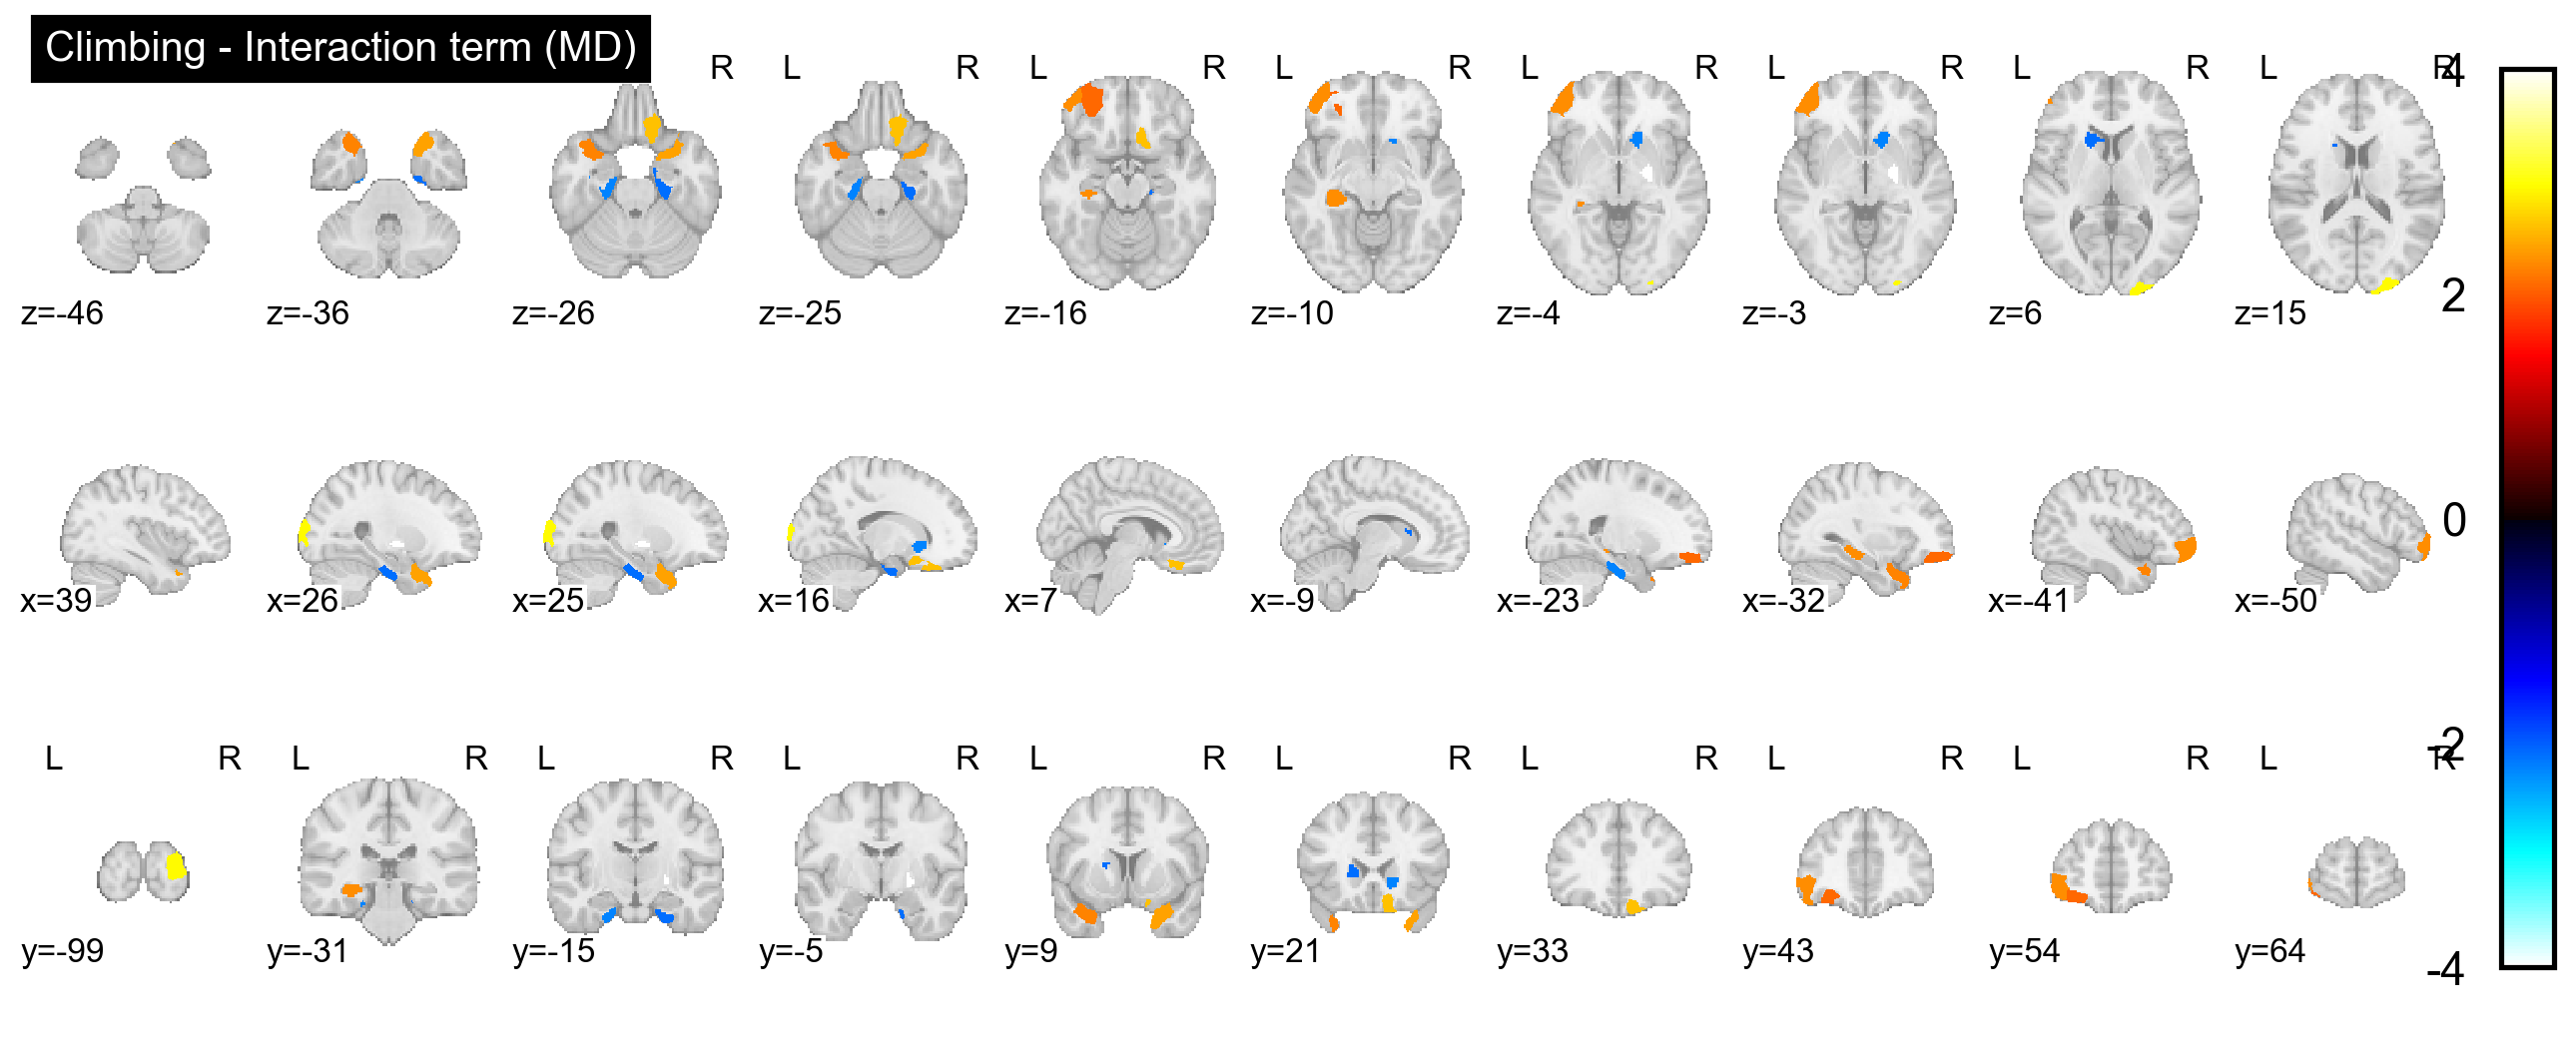

In [ ]:
plotting.plot_stat_map(
    atlas_mod, title="Climbing - Interaction term (MD)", threshold=0, display_mode="mosaic", cut_coords=10
)

In [ ]:
from scipy.stats import ttest_1samp, ttest_rel
diff_results = {}

for metric, df in metric_data.items():
    diff_results[metric] = {}
    # if metric != "adc":
    #     continue
    for group in ["all", "Climbing", "Bjj"]:
        if group == "all":
            key = "athletes"
            group_df = df.copy()
        else:
            key = group.lower()
            group_df = df[df["group"] == group]
        cs_stats = output_dir.parent / "fig1" / metric / f"{key}_vs_controls" / "stats.csv"
        cs_stats = pd.read_csv(cs_stats)
        significant_rois = cs_stats[cs_stats["p_value_corrected"] < 0.05]
        diff_stats = parcels.copy()

        for i in significant_rois.index:
            roi_df = group_df[group_df[config.REGION_COL] == significant_rois.loc[i, config.REGION_COL]]
            roi_df.loc[roi_df["subject_code"].str.contains("BJJC"), "condition"] = "Ccontrol"
            roi_df.loc[roi_df["subject_code"].str.contains("CLMC"), "condition"] = "Ccontrol"
            tidy = prepare_roi_longitudinal(roi_df, cfg)
            tidy = tidy[tidy["time_months"] < 12 * 2]
            d = tidy.loc[tidy["tp_label"].isin(["pre", "post"])].copy()
            d = d.loc[tidy["sport"].str.lower().isin(["bjj", "climbing"])].copy()
            has_both = d.groupby("subject_code")["tp_label"].transform(
                lambda s: {"pre", "post"}.issubset(set(s))
            )
            d = d[has_both].copy()
            d_before = d[d["tp_label"] == "pre"].set_index("subject_code")
            d_after = d[d["tp_label"] == "post"].set_index("subject_code")

            d_learners_before = d_before[d_before["condition"] == "Learner"]
            d_athletes_before = d_before[d_before["condition"] != "Learner"]
            d_learners_after = d_after[d_after["condition"] == "Learner"]
            d_athletes_after = d_after[d_after["condition"] != "Learner"]

            t,p = ttest_rel(d_learners_after["y"], d_learners_before.loc[d_learners_after.index,"y"])
            diff_stats.loc[i, "t_learners"] = t
            diff_stats.loc[i, "p_learners"] = p
            t,p = ttest_rel(d_athletes_after["y"], d_athletes_before.loc[d_athletes_after.index,"y"])
            diff_stats.loc[i, "t_athletes"] = t
            diff_stats.loc[i, "p_athletes"] = p

            # df_diff = d_after.copy()
            # df_diff["delta"] = df_diff["y"] - d_before["y"].values
            # df_diff["relative_delta"] = df_diff["delta"] / d_before["y"].values
            # df_diff["delta_days"] = (d_after["scan_dt"] - d_before["scan_dt"].values).dt.days

            # df_learners = df_diff[df_diff["condition"] == "Learner"]
            # df_athletes = df_diff[df_diff["condition"] != "Learner"]
            # t, p = ttest_1samp(df_learners["delta"], 0)
            # diff_stats.loc[i, "t_learner"] = t
            # diff_stats.loc[i, "p_learner"] = p
            # t, p = ttest_1samp(df_athletes["delta"], 0)
            # diff_stats.loc[i, "t_athlete"] = t
            # diff_stats.loc[i, "p_athlete"] = p
        for pcol in ["p_learners", "p_athletes"]:
            qcol = pcol.replace("p_", "q_")
            mask = diff_stats[pcol].notna()
            if mask.any():
                diff_stats.loc[mask, qcol] = multipletests(diff_stats.loc[mask, pcol], method="fdr_bh")[1]
        # multiple tests
        
        diff_results[metric][group.lower()] = diff_stats
        # break
    # break

In [ ]:
import nibabel as nib
from nilearn import plotting

metric = "gm_vol"
metric_vis = {"adc":"MD", "gm_vol": "GM Volume"}
sport = "all"
fdr_corrected = True

for sport in ["all","climbing","bjj"]:
    for cond in ["learners","athletes"]:
        for metric in metrics:
            metric_dir = output_dir  / sport / "athletes_guided" / metric / cond
            metric_dir.mkdir(parents=True, exist_ok=True)
            vis_df = diff_results[metric][sport.lower()]
            vis_df.index = parcels.index

            vis_config = Fig1Config()
            vis_config.VMIN = vmin
            vis_config.VMAX = vmax

            #     break
            # break
            plotter = BrainPlotter(vis_config)

            plotter.plot_single_metric(
                results_df=vis_df,
                metric_key=f"{metric}_{sport}_{cond}",
                output_dir=metric_dir,
                p_column=f"p_{cond}" if fdr_corrected else f"q_{cond}",
                value_column=f"t_{cond}",
            )
            plt.close("all")
    #         break
    #     break
    # break

2025-08-27 17:31:17.636 | INFO     | athletes_brain.fig1.brain_visualization:plot_single_metric:276 - Creating brain plots for gm_vol_all_learners
2025-08-27 17:31:17.636 | INFO     | athletes_brain.fig1.brain_visualization:setup_surfaces:30 - Setting up brain surfaces and parcellations
2025-08-27 17:31:17.639 | SUCCESS  | athletes_brain.fig1.brain_visualization:setup_surfaces:39 - Brain surfaces and parcellations loaded successfully
2025-08-27 17:31:17.640 | INFO     | athletes_brain.fig1.brain_visualization:prepare_value_maps:57 - Preparing value maps for t_learners
2025-08-27 17:31:17.659 | INFO     | athletes_brain.fig1.brain_visualization:prepare_value_maps:97 - Prepared maps with 200 LH, 200 RH, and 54 subcortical regions
2025-08-27 17:31:17.659 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:121 - Creating cortical surface plots
2025-08-27 17:31:17.671 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:143 - Plotting left hemisp

In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
vis_config = Fig1Config()

# cmaps = config.get_colormaps()
# cmap = cmaps["weighted"]
vis_config.COLORMAP = "coolwarm"

vis_config.VMIN = -3
vis_config.VMAX = 3
plotter = BrainPlotter(vis_config)

NameError: name 'Fig1Config' is not defined

In [ ]:

effect = "factor_interaction"
is_learner = effect.startswith("L") 

plotter.plot_single_metric(
    results_df=stats,
    metric_key=effect,
    output_dir=output_dir,
    p_column=f"{effect}_p" if not is_learner else effect.replace("beta",'p'),
    value_column=f"{effect}_z" if not is_learner else effect.replace("beta",'z')
)

: 